In [1]:
from collections import Counter
import os
from glob import glob

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from networkx.drawing.nx_agraph import to_agraph
from networkx.readwrite.gpickle import read_gpickle
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

import numbers


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
# Function to convert adjacency matrix (in the form of a pandas dataframe) to adjacency list
def adjacency_matrix_to_list(adj_matrix):
    adj_list = {}
    for node in adj_matrix.index:
        adj_list[node] = list(adj_matrix.columns[adj_matrix.loc[node] == 1])
    return adj_list

# Function to perform DFS and find all root-to-leaf paths
def find_paths(adj_list, node, path, paths):
    path.append(node)
    if len(adj_list[node]) == 0:
        paths.append(path.copy())
    else:
        for neighbor in adj_list[node]:
            find_paths(adj_list, neighbor, path, paths)
    path.pop()
    
def get_nodes(adj_matrix):
    nodes = list(adj_matrix.index)
    internal_nodes = [node for node in nodes if adj_matrix.loc[node].sum() > 0]
    return internal_nodes


# Function to create dataframe where leaf nodes are index and internal nodes are columns
def create_leaf_internal_df(adj_matrix):
    # Get list of leaf nodes
    leaf_nodes = [node for node in adj_matrix.index if adj_matrix.loc[node].sum() == 0]
    # Get list of internal nodes
    internal_nodes = [node for node in adj_matrix.index if adj_matrix.loc[node].sum() > 0]
    # Initialize dataframe with leaf nodes as index and internal nodes as columns
    leaf_internal_df = pd.DataFrame(0, index=leaf_nodes, columns=internal_nodes)
    return leaf_internal_df

def set_groups(leaf_internal_df, paths):
    leaf_internal_df = leaf_internal_df.copy()
    for path in paths: 
        leaf_node = path[-1]
        for node in path[:-1]:
            leaf_internal_df.loc[leaf_node, node] = 1 
    return leaf_internal_df



def group_nodes_with_same_values(df):
    # Group columns by unique rows
    grouped = df.groupby(df.columns.tolist()).groups

    # Extract column names as lists
    grouped_columns = [list(group) for group in grouped.values()]

    return grouped_columns

In [3]:
datasets = ['A1_06', 'A1_30']#, 'JH', 'YFV2003']


In [4]:
meta_data_timepoint = pd.read_csv('/home/carler/lab/t_cell/meta_data/2023_04_06_A1_06_A1_30_YFV2003_JH_meta_data_invivo_t_cell_mito_project.csv', index_col=0)


In [5]:
mem_eff_score = {}
for donor in datasets: 
    mem_eff_score[donor] = pd.read_csv(f'/home/carler/lab/t_cell/meta_data/mem_eff_score/{donor}_mem_eff.csv', index_col=0)


In [46]:
graph_dicts_all = {}
meta_data_all = {}
test = ""
for donor in datasets: 
    graph_dict = {}
    meta_data = {}
    for path in list(glob(os.path.join(f'/home/carler/lab/t_cell/phylogeny/data/output/P20407/2023_4_27_mt-scite_2_pos_filter/{donor}/0.0556*'))):
        clone = path.split('0.0556_')[1]
        if clone in ["A39", "A397", "A41", "A171", "A28", "A48", "B102", "B243"]: 
            continue
        adj_matrix_clone = nx.drawing.nx_pydot.read_dot(f"{path}/0.0556_{clone}_map0.gv")
        adj_matrix_clone.remove_node('\\n')
        adj_matrix_clone = nx.to_pandas_adjacency(adj_matrix_clone)
        if clone == 'A1': 
            test = adj_matrix_clone
#        adj_matrix_clone = adj_matrix_clone.loc[adj_matrix_clone.index[1:], adj_matrix_clone.columns[1:]]    
        graph_dict[clone] = adj_matrix_clone
        meta_data[clone] = pd.read_csv(f"{path}/0.0556_meta_data_{clone}.csv", index_col=0).T
    graph_dicts_all[donor] = graph_dict
    meta_data_all[donor] = meta_data

for donor in datasets: 
    graph_dict = graph_dicts_all[donor]     
    meta_data = meta_data_all[donor]   
    for clone in graph_dict.keys(): 
        nodes = get_nodes(graph_dict[clone])
        root = max(nodes)
        adj_list = adjacency_matrix_to_list(graph_dict[clone])
        paths = []
        path = []
        find_paths(adj_list, root, path, paths)
        leaf_internal_df = create_leaf_internal_df(graph_dict[clone])
        leaf_internal_df = set_groups(leaf_internal_df, paths)
        leaf_internal_df.index = [int(x[1:]) for x in leaf_internal_df.index]
        leaf_internal_df = leaf_internal_df.sort_index()[leaf_internal_df.columns.sort_values()]
        graph_dict[clone] = leaf_internal_df
        graph_dict[clone] = graph_dict[clone].drop(graph_dict[clone].columns[-1], axis=1)
        graph_dict[clone].index = meta_data[clone].index
        graph_dict[clone].columns = meta_data[clone].columns
        graph_dict[clone] = graph_dict[clone]
    graph_dicts_all[donor] = graph_dict    

In [7]:
test_shuff = graph_dicts_all['A1_06']['A1']

In [8]:
grouped_by_node = {}
for donor in datasets: 
    grouped_by_node[donor] = {}
    for clone, matrix in graph_dicts_all[donor].items(): 
        prev_index = matrix.index
        group_input = matrix.sample(frac=1).reset_index(drop=True)
        group_input.index = prev_index
        grouped_by_node[donor][clone] = group_nodes_with_same_values(group_input)
        #grouped_by_node[donor][clone] = group_nodes_with_same_values(matrix)

In [9]:
mean_mem_eff_different_clone = {}
for donor in datasets: 
    mean_mem_eff_different_clone[donor] = {}
    for clone, groups in grouped_by_node[donor].items(): 
        clone_group_difference = []
        for group in groups: 
            if len(group) < 2 or len(group) > 7: 
                continue
            try:
                clone_group_difference.append(mem_eff_score[donor].loc[group, 'Celltype'].mean())
            except: 
                print(group)
        if len(clone_group_difference) < 2: 
            continue
        mean_mem_eff_different_clone[donor][clone] = clone_group_difference

In [ ]:
for donor in datasets: 
    plot_list = []
    for clone, mean_values in mean_mem_eff_different_clone[donor].items(): 
        plot_list = plot_list + mean_values

    fig, ax = plt.subplots()
    sns.scatterplot(plot_list, ax=ax)
    plt.ylim((-0.5, 0.5))
    plt.xticks((0, len(plot_list)))
    plt.title(clone)
    plt.show()

In [ ]:
for donor in datasets: 
    plot_list = []
    for clone, mean_values in mean_mem_eff_different_clone[donor].items(): 
        plot_list = plot_list + mean_values

    fig, ax = plt.subplots()
    sns.scatterplot(plot_list, ax=ax)
    plt.ylim((-0.5, 0.5))
    plt.xticks((0, len(plot_list)))
    plt.title(clone)
    plt.show()

In [12]:
grouped_by_node = {}
for donor in datasets: 
    grouped_by_node[donor] = {}
    for clone, matrix in graph_dicts_all[donor].items(): 
        prev_index = matrix.index
        group_input = matrix.sample(frac=1).reset_index(drop=True)
        group_input.index = prev_index
        grouped_by_node[donor][clone] = group_nodes_with_same_values(group_input)
        #grouped_by_node[donor][clone] = group_nodes_with_same_values(matrix)

In [13]:
mem_eff_different_clone = {}
for donor in datasets: 
    mem_eff_different_clone[donor] = {}
    for clone, groups in grouped_by_node[donor].items(): 
        clone_group_difference = []
        for group in groups: 
            if len(group) < 2 or len(group) > 2: 
                continue
            try:
                clone_group_difference.append(list(mem_eff_score[donor].loc[group, 'Celltype'].values)) 
            except: 
                print(group)
        if len(clone_group_difference) < 2: 
            continue
        mem_eff_different_clone[donor][clone] = clone_group_difference

In [ ]:
for donor in datasets: 
    plot_list = []
    for clone, all_values in mem_eff_different_clone[donor].items(): 
        plot_list = plot_list + all_values
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.scatterplot(list(map(list, zip(*plot_list))), ax=ax)#, legend=False)
    plt.ylim((-0.5, 0.5))
    plt.title(donor + ' real')
    plt.show()
    plt.figure()
    reg_test = pd.DataFrame(plot_list)
    sns.regplot(x=reg_test[0], y=reg_test[1])
    plt.title(donor + ' real')

In [ ]:
for donor in datasets: 
    plot_list = []
    for clone, all_values in mem_eff_different_clone[donor].items(): 
        plot_list = plot_list + all_values
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.scatterplot(list(map(list, zip(*plot_list))), ax=ax)#, legend=False)
    plt.ylim((-0.5, 0.5))
    plt.title(donor + ' shuff')
    plt.show()
    plt.figure()
    reg_test = pd.DataFrame(plot_list)
    sns.regplot(x=reg_test[0], y=reg_test[1])
    plt.title(donor + ' shuff')

In [47]:
removed_all_singleton_mutations = {}

for donor in datasets: 
    removed_all_singleton_mutations[donor] = {}
    for clone, matrix in graph_dicts_all[donor].items(): 
        drop_cols = []
        for col in matrix.columns:
            if matrix[col].sum() == 1: 
                drop_cols.append(col)
        temp_df = matrix.drop(drop_cols, axis=1)
        removed_all_singleton_mutations[donor][clone] = temp_df

In [48]:
grouped_by_node_no_single = {}
for donor in datasets: 
    grouped_by_node_no_single[donor] = {}
    for clone, matrix in removed_all_singleton_mutations[donor].items(): 
        prev_index = matrix.index
        group_input = matrix.sample(frac=1).reset_index(drop=True)
        group_input.index = prev_index
        grouped_by_node_no_single[donor][clone] = group_nodes_with_same_values(group_input)
        #grouped_by_node[donor][clone] = group_nodes_with_same_values(matrix)

In [61]:
mem_eff_different_clone_no_single = {}
for donor in datasets: 
    mem_eff_different_clone_no_single[donor] = {}
    for clone, groups in grouped_by_node_no_single[donor].items(): 
        clone_group_difference = []
        for group in groups: 
            #if len(group) < 2: 
            #    continue
            try:
                clone_group_difference.append(list(mem_eff_score[donor].loc[group, 'Celltype'].values)) 
            except: 
                print(group)
        if len(clone_group_difference) < 2: 
            continue
        mem_eff_different_clone_no_single[donor][clone] = clone_group_difference

In [62]:
from scipy.stats import f_oneway


In [67]:
p_vals = {}
f_stats = {}
for donor in datasets:
    p_vals[donor] = []
    f_stats[donor] = []
    for clone, groups in mem_eff_different_clone_no_single[donor].items(): 
        f_stat, p_val = f_oneway(*groups)
        p_vals[donor].append(p_val)
        f_stats[donor].append(f_stat)
        if p_val < 0.05: 
            print(clone)
            print(p_val)
            print(f_stat)
    

A362
0.006709104963168622
8.162009496343414
A0
0.030909531285210064
5.539747645170977
A212
0.03613682881873213
5.85050253258801
B7
0.03123324074004964
5.329702710770986


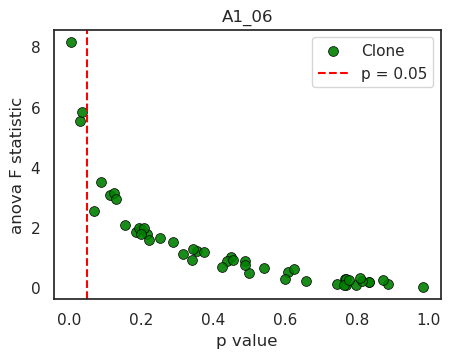

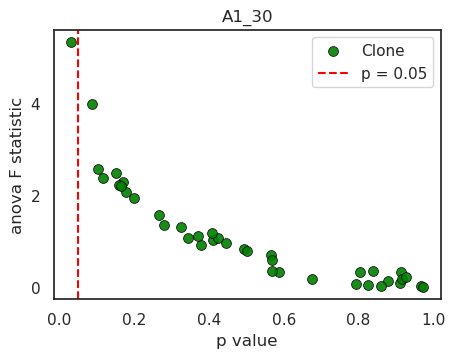

In [99]:
for donor in datasets: 
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(5,3.5))
    sns.scatterplot(x=p_vals[donor], y=f_stats[donor], ax=ax, label='Clone', s=50, edgecolor='black', color='green', alpha=0.90)
    ax.axvline(x=0.05, linestyle='--', color='red', label='p = 0.05')
    plt.xlabel("p value")
    plt.ylabel('anova F statistic')
    plt.title(donor)
    plt.legend()
    plt.xticks(np.arange(0, 1.1, 0.2))
    plt.yticks(np.arange(0, max(f_stats[donor]), 2))
    plt.savefig(f'anova_oneway_{donor}.pdf')

In [69]:
mem_eff_different_clone_no_single[donor].keys()

dict_keys(['B71', 'B7', 'B305', 'B67', 'B191', 'B63', 'B664', 'B257', 'B73', 'B24', 'B39', 'B60', 'B324', 'B14', 'B101', 'B122', 'B51', 'B85', 'B325', 'B18', 'B225', 'B72', 'B66', 'B83', 'B488', 'B293', 'B44', 'B12', 'B94', 'B214', 'B211', 'B100', 'B81', 'B185', 'B117', 'B165', 'B57', 'B858', 'B121'])